In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()


Instructions can be found at [Classifying Palmer Penguins](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-penguins.html).

## Explore
The [penguins](https://allisonhorst.github.io/palmerpenguins/) dataset features measurements for three penguin species observed in the Palmer Archipelago, Antarctica (more information in link).

Information on the data contained: [Penguin size, clutch, and blood isotope data for foraging adults near Palmer Station, Antarctica](https://allisonhorst.github.io/palmerpenguins/reference/penguins_raw.html)

In [2]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)


### Lengths
We examine the first quantitative elements of the dataset - the penguins' Culmen and Flipper lengths, and see how they relate to the penguins' species.

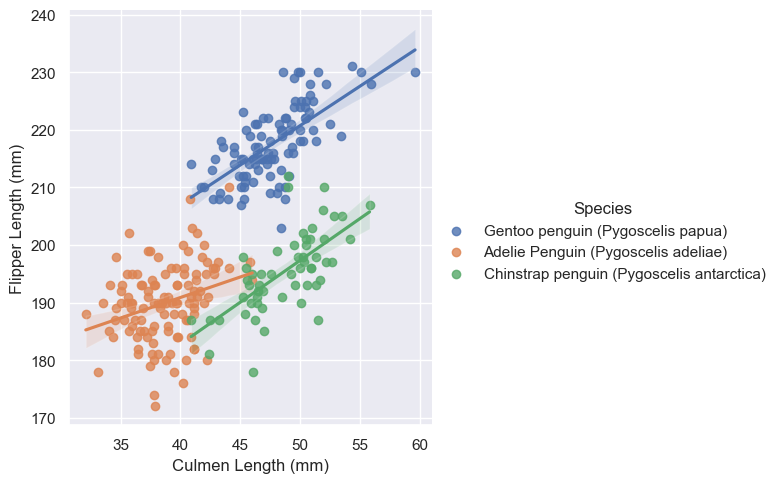

In [38]:
lengthsPlot = sns.lmplot(train, x="Culmen Length (mm)",
                         y="Flipper Length (mm)", hue="Species")


These are three pretty distinct clusters, though with some overlap!

As such, we could probably say that the penguins with the smallest culmen and flipper lengths are probably Adelie penguins.

### Blood isotopes
Next, we look at isotope data for these penguins:

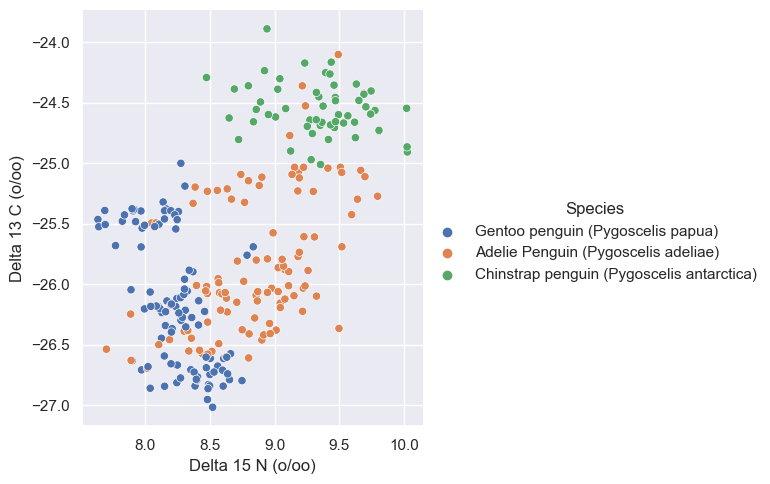

In [40]:
isotopesPlot = sns.relplot(
    train, x="Delta 15 N (o/oo)", y="Delta 13 C (o/oo)", hue="Species")


These clusters turned out to be pretty inseparable.

Does blood isotope data have to do with where these penguins live?

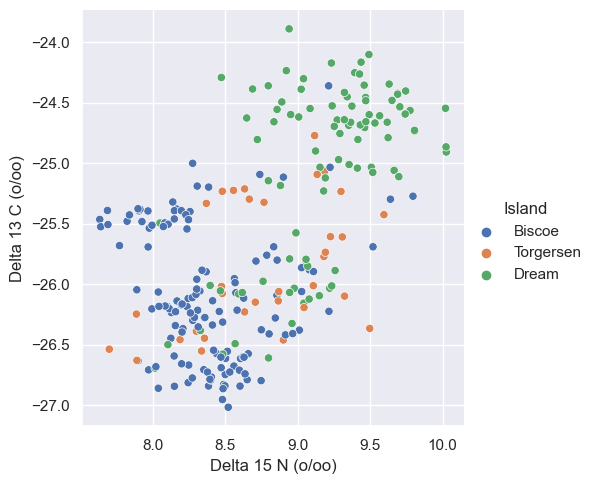

In [41]:
isotopesIslandPlot = sns.relplot(
    train, x="Delta 15 N (o/oo)", y="Delta 13 C (o/oo)", hue="Island")


The answer is probably no; we see no patterns at all here.

### Island
So where do these penguins live?

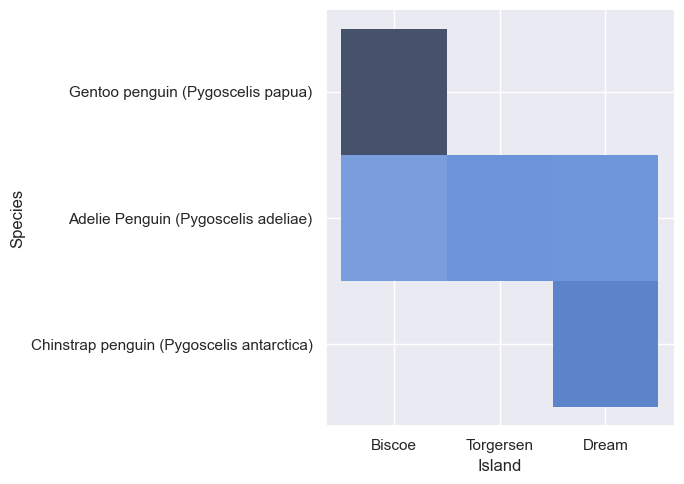

In [59]:
livePlot = sns.displot(train, x="Island", y="Species", aspect=1.4)


In [74]:
train.groupby(["Island", "Sex", "Species"]).count()[["Region"]]


Region
Island    Sex    Species                                          
Biscoe    .      Gentoo penguin (Pygoscelis papua)               1
          FEMALE Adelie Penguin (Pygoscelis adeliae)            19
                 Gentoo penguin (Pygoscelis papua)              42
          MALE   Adelie Penguin (Pygoscelis adeliae)            16
                 Gentoo penguin (Pygoscelis papua)              54
Dream     FEMALE Adelie Penguin (Pygoscelis adeliae)            20
                 Chinstrap penguin (Pygoscelis antarctica)      29
          MALE   Adelie Penguin (Pygoscelis adeliae)            20
                 Chinstrap penguin (Pygoscelis antarctica)      27
Torgersen FEMALE Adelie Penguin (Pygoscelis adeliae)            18
          MALE   Adelie Penguin (Pygoscelis adeliae)            19

We observe that, Gentoo penguins only live on the Biscoe Islands, and Chinstrap penguins on Dream Island; Adelie penguins happily (or at least hopefully happily) live on all three islands.

Also, Torgensen Island only has Adelie penguins; the other islands have at least two species.

Looking at sex, the penguins on each island are pretty evenly split between male and female.

Note this might only be specific to our test-train split, so we need to be cautious of not over-fitting - we cannot say, for example, that a penguin on Torgensen Island is 100% Adelie.


## Model
### Prepare data
We prepare `Species` as labels, and then other features with `pd.get_dummies()`.

Rows with invalid `Sex` fields or fields with `NA` are dropped.

Several identifying columns, like `Individual ID`, are also dropped.

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])


def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID",
                 "Date Egg", "Comments", "Region"], axis=1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis=1)
    df = pd.get_dummies(df)
    return df, y


X_train, y_train = prepare_data(train)

X_train.head()


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0


### Feature selection

We need to select 3 features for our classification model.

Since one of these need to be qualitative, we may have to look at more than 3.

From `scikit-learn`, [1.13. Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html):

#### Univariate statistical tests

We can apply univariate statistical tests to find the statistically "best" features.

For classification, we have three scores available:

- [`chi2`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) is for contigency tables, or at least non-negative values.
Since the column `Delta 13 C (o/oo)` contains negative values, we cannot use this score.
- [`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) computes the ANOVA F-value.
- [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) estimates mutual information for a discrete target variable. 

We use [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to remove all but the best $K$ features:

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=3)
X_new = selector.fit_transform(X_train, y_train)
# scikit-learn does not keep names ):
# https://stackoverflow.com/a/41041230
X_train.loc[:, selector.get_support()].head()


,Culmen Length (mm),Flipper Length (mm),Body Mass (g)
1,45.1,215.0,5000.0
2,41.4,202.0,3875.0
3,39.0,185.0,3650.0
4,50.6,193.0,3800.0
5,33.1,178.0,2900.0


We see that these three are all quantitative.

Therefore, we keep the top 2:

In [5]:
quant_selector = SelectKBest(f_classif, k=2)
X_new = quant_selector.fit_transform(X_train, y_train)
# scikit-learn does not keep names ):
# https://stackoverflow.com/a/41041230
X_train.loc[:, quant_selector.get_support()].head()


,Culmen Length (mm),Flipper Length (mm)
1,45.1,215.0
2,41.4,202.0
3,39.0,185.0
4,50.6,193.0
5,33.1,178.0


And then find the best qualitative feature:

In [6]:
qual_selector = SelectKBest(f_classif, k=6)
X_new = qual_selector.fit_transform(X_train, y_train)
# scikit-learn does not keep names ):
# https://stackoverflow.com/a/41041230
X_train.loc[:, qual_selector.get_support()].head()


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 13 C (o/oo),Island_Biscoe
1,45.1,14.5,215.0,5000.0,-25.46569,1
2,41.4,18.5,202.0,3875.0,-25.42621,0
3,39.0,18.7,185.0,3650.0,-26.03442,0
4,50.6,19.4,193.0,3800.0,-24.97134,0
5,33.1,16.1,178.0,2900.0,-26.15775,0


The result seems to be on which island does the penguin reside.

We include all three `Island` features since only checking whether they live on Biscoe does not make sense.

In [7]:
cols = ['Culmen Length (mm)', 'Flipper Length (mm)',
        'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']



#### Performance on Logistic Regression

We can also *recursively* consider smaller sets of features, and evaluate how this performs on a certain model.

The latter, with cross validation, is availiable as a built-in function [`RFECV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV).

For the cross-validation step, we use a strafied 5-fold cross-validator on logistic regression.

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

rfecv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=KFold(10),
    scoring="accuracy",
    min_features_to_select=2
)
rfecv.fit(X_train, y_train)
X_train.loc[:, rfecv.get_support()].head()


,Culmen Length (mm),Culmen Depth (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Dream,Sex_FEMALE
1,45.1,14.5,7.63220,-25.46569,0,1
2,41.4,18.5,9.59462,-25.42621,0,0
3,39.0,18.7,9.22033,-26.03442,1,0
4,50.6,19.4,9.28153,-24.97134,1,0
5,33.1,16.1,9.04218,-26.15775,1,1


`RFECV` ranks 6 features as equally important - but why?

Here are the importance scores that `RFECV` determined:

In [116]:
X_train.columns
rfecv.ranking_
d = pd.DataFrame(columns=X_train.columns)
# Use `df.loc[len(df)] = arr` – rafaelc Oct 8, 2019 at 19:43
# https://stackoverflow.com/q/58292901
d.loc["Importance"] = rfecv.ranking_
d


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
Importance,1,1,5,9,1,1,2,1,4,8,6,7,1,3


And here is the mean test accuracy of the process with different number of features selected:

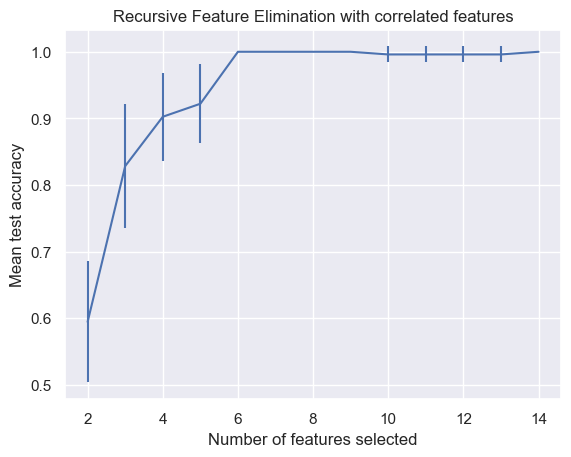

In [9]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(2, n_scores + 2),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination with correlated features")
plt.show()


We see that, with 10-fold cross-validation, the *mean test accuracy* only got to 100% after selecting 6 features.

Therefore, `RFECV` is marking them as "equally important".

We are thus resorting to the columns we selected in [Univariate statistical tests](#univariate-statistical-tests).

### Modeling
#### Logistic regression
The modeling process is more straightforward. Here, we use logistic regression:

In [10]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)


0.96875

The model performed well, although it did not reach 100% accuracy on the training set.

#### Random forest
When we maintaining an ensemble of decision trees, we can let them vote on the best category.

This method was state-of-the-art before the rise of neural networks. <sup>\[[citation needed](https://xkcd.com/285/)\]</sup>

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'max_depth': [2, 5, 7, 9, 13]
}

RF = RandomForestClassifier(max_features=1)

GRF = GridSearchCV(RF, param_grid, cv=10)
GRF.fit(X_train[cols], y_train)
GRF.best_params_


{'max_depth': 7, 'n_estimators': 30}

Here, we use a grid search with cross-validation ([`GridSearchCV`](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search)) to identify the best hyperparameters among a predefined `param_grid`.

Our `GridSearchCV` has cross-validated our Random Forest models, and selected the best parameters.

We can then access our best estimator with `GRF.best_estimator_`.

## Testing
Now that we have two models, we can test their performance on the test set.

### Logistic regression
First, gather the data and run logistic regression on it:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])


def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID",
                 "Date Egg", "Comments", "Region"], axis=1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis=1)
    df = pd.get_dummies(df)
    return df, y


X_train, y_train = prepare_data(train)

X_train.head()


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0


In [124]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
LR.score(X_test[cols], y_test)


0.9411764705882353

This score is less than we had in the training set, and also not what this blog post expected (100%).

We can take a look at what happened through plotting the decision regions:

In [126]:
# https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-penguins.html#plotting-decision-regions
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch


def plot_regions(model, X, y):

    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]

    fig, axarr = plt.subplots(1, len(qual_features), figsize=(7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(), x0.max(), 501)
    grid_y = np.linspace(x1.min(), x1.max(), 501)
    xx, yy = np.meshgrid(grid_x, grid_y)

    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
        XY = pd.DataFrame({
            X.columns[0]: XX,
            X.columns[1]: YY
        })

        for j in qual_features:
            XY[j] = 0

        XY[qual_features[i]] = 1

        p = model.predict(XY)
        p = p.reshape(xx.shape)

        # use contour plot to visualize the predictions
        axarr[i].contourf(xx, yy, p, cmap="jet", alpha=0.2, vmin=0, vmax=2)

        ix = X[qual_features[i]] == 1
        # plot the data
        axarr[i].scatter(x0[ix], x1[ix], c=y[ix], cmap="jet", vmin=0, vmax=2)

        axarr[i].set(xlabel=X.columns[0],
                     ylabel=X.columns[1])

        patches = []
        for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
            patches.append(Patch(color=color, label=spec))

        plt.legend(title="Species", handles=patches, loc="best")

        plt.tight_layout()


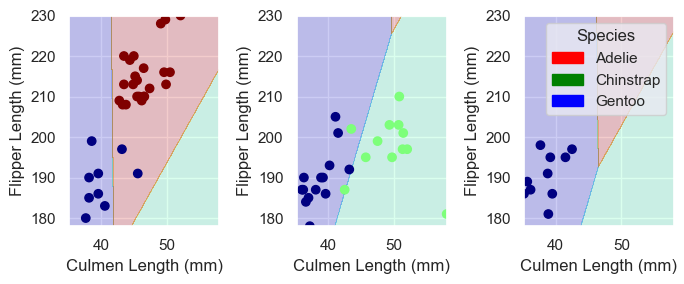

In [132]:
plot_regions(LR, X_test[cols], y_test)


On each island, it looked like the logistic regression found approximate lines that separated each species.

However, there is some overlap between each region, so accuracy was less than 100%.

### Random forest
How did random forest do? Let us find out.

In [130]:
GRF.best_estimator_.score(X_test[cols], y_test)


0.9558823529411765

This is marginally better, but still not quite at 100% yet.

Again, here are the decision boundaries:

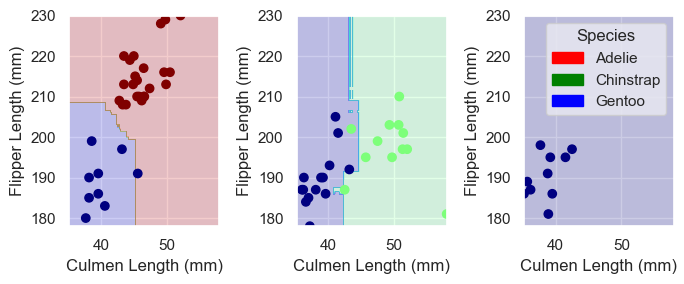

In [135]:
plot_regions(GRF.best_estimator_, X_test[cols], y_test)


Here, the shape of the decision boundaries suggest overfitting - perhaps we should revisit `param_grid` and find better hyperparameters.